In [77]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.transforms import transforms

## Quelques fonctions utiles

Une fonction pour ajouter du bruit (gaussien ou speckle), deux fonctions pour calculer le SNR et une fonction de normalisation entre 0 et 1.

In [78]:
def add_noise(img, noiseType="gaussian", mean=0, var=1):
    """
    Fonction ajoutant du bruit à une image.

    :param img: Image à bruiter.
    :param noiseType: Type de bruit.
    :param mean: Moyenne du bruit.
    :param var: Variance du bruit.
    :return: Image bruitée.
    """
    row, col = 64, 64
    img = img.astype(np.float32)
    sigma = var ** .5

    # Ajout de bruit Gaussien
    if noiseType == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    # Ajout de bruit de type Speckle
    if noiseType == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

def snr(img1, img2):
    """
    Fonction calculant le SNR d'une image.

    :param img1: Image bruitée.
    :param img2: Image non bruitée
    :return: SNR
    """
    sz = img1.shape
    acc_num = 0
    acc_den = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_num += img1[i][j] ** 2
            acc_den += (img1[i][j] - img2[i][j]) ** 2

    return acc_num / acc_den

def psnr(img1, img2):
    """
    Fonction calculant le PSNR d'une image. Le PSNR est une mesure de distorsion utilisée en image numérique, tout particulièrement en compression d'image.

    :param img1: Image bruitée.
    :param img2: Image non bruitée
    :return: PSNR
    """
    sz = img1.shape
    acc_mse = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_mse += (img1[i][j] - img2[i][j]) ** 2

    acc_mse /= (sz[0] * sz[1])

    return 10 * np.log(255 ** 2 / acc_mse)

def normalisation(X):
    """
    Fonction normalisant une matrice.

    :param X: Matrice à normaliser.
    :return: Matrice normalisée.
    """
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

## Extraction des données

Les données sont chargées depuis un dossier, mélangées, réparties en un dataset de test et un dataset d'entrainement.

In [79]:
data = []
imgs_path = "data"

kernel = np.ones((2,2),np.uint8)

for filename in os.listdir(imgs_path):
            f = os.path.join(imgs_path, filename)
            data.append(cv2.threshold(cv2.dilate(cv2.imread(f, 0), kernel), 20, 255, cv2.THRESH_BINARY)[1])

random.shuffle(data)  #

xtrain = data[:14000]
xtest = data[14000:]

## Ajout du bruit sur les images

Un bruit Gaussien est ajouté à toutes les images des bases de test et d'entraînement.

In [80]:
noises = ["gaussian", "speckle"]
mean = 0
var = 10000.
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0
noise_id = 0

# Ajout du bruit à la base d'entraînement
traindata = np.zeros((14000, 64, 64))

for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noiseType=noises[noise_id], mean=mean, var=var)

print("\n{} noise addition completed to images".format(noises[noise_id]))

# Ajout du bruit à la base de test
testdata = np.zeros((956, 64, 64))

for idx in tqdm(range(len(xtest))):
    testdata[idx] = add_noise(xtest[idx], noiseType=noises[noise_id], mean=mean, var=var)

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 14000/14000 [00:01<00:00, 11998.80it/s]



gaussian noise addition completed to images


100%|██████████| 956/956 [00:00<00:00, 12016.98it/s]


gaussian noise addition completed to images


## Affichage d'imagettes

Trois imagettes sont affichées dans leur forme initiale et dans leur forme bruitée

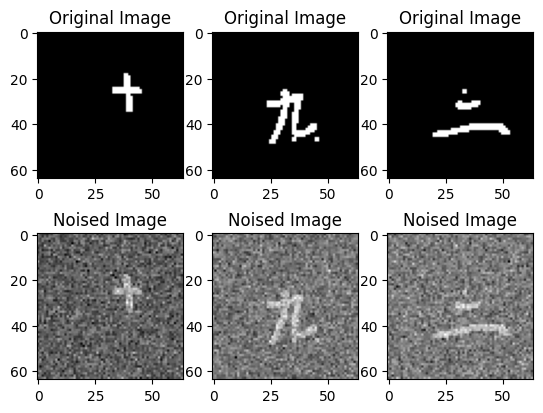

SNR:  0.2727423377347475
PSNR:  18.724331909676497


In [81]:
f, axes = plt.subplots(2, 3)

axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

axes[0, 1].imshow(xtrain[5000], cmap="gray")
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[5000], cmap='gray')
axes[1, 1].set_title("Noised Image")

axes[0, 2].imshow(xtrain[10000], cmap='gray')
axes[0, 2].set_title("Original Image")
axes[1, 2].imshow(traindata[10000], cmap="gray")
axes[1, 2].set_title("Noised Image")
plt.show()

snr_estim = 0
psnr_estim = 0

for i in range(1000):
    snr_estim += snr(xtrain[i], traindata[i])
    psnr_estim += psnr(xtrain[i], traindata[i])

print("SNR: ", snr_estim/1000)
print("PSNR: ", psnr_estim/1000)

## Création de la classe Dataset

In [82]:
class noisedDataset(Dataset):
    def __init__(self, datasetnoised, datasetclean, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]

        if self.transform is not None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return xNoise, xClean

## Création des Dataloader

Les Dataloaders permettant d'avoir accès aux données pour l'entrainement et le test.

Un léger préprocessing est effectué sur les images (Redimensionnement de 64x64 vers 32x32).

In [83]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

trainset = noisedDataset(traindata, xtrain, tsfms)
testset = noisedDataset(testdata, xtest, tsfms)

batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

## Création de l'Autoancodeur de Débruitage

La classe contient différents encodeurs et décodeurs qui peuvent être utilisés en modifiant la fonction forward

In [84]:
from torch import nn

class denoising_model(nn.Module):
    def __init__(self):
        super(denoising_model, self).__init__()

        # Encodeur et décodeur à base de couches Denses
        self.encoderDense = nn.Sequential(
            nn.Linear(32 * 32, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.decoderDense = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 32 * 32),
            nn.Sigmoid(),
        )

        # Encodeur et décodeur à base de couches de Convolution 1D
        self.encoderConv1D = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )
        self.decoderConv1D = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        # Encodeur et décodeur à base de couches de Convolution 2D
        self.encoderConv2D = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )
        self.decoderConv2D = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoderConv1D(x)
        x = self.decoderConv1D(x)

        return x

## Création du modèle

Le modèle est créé puis affiché dans cette section. Les variables nécessaires pour l'entrainement sont définies également.

In [85]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Création du modèle
model = denoising_model().to(device)
summary(model, (1, 32*32))

# Définition de la loss et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

epochs = 50
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 1024]             512
              ReLU-2            [-1, 128, 1024]               0
         MaxPool1d-3             [-1, 128, 512]               0
            Conv1d-4              [-1, 64, 512]          24,640
              ReLU-5              [-1, 64, 512]               0
         MaxPool1d-6              [-1, 64, 256]               0
            Conv1d-7              [-1, 32, 256]           6,176
              ReLU-8              [-1, 32, 256]               0
         MaxPool1d-9              [-1, 32, 128]               0
           Conv1d-10              [-1, 16, 128]           1,552
             ReLU-11              [-1, 16, 128]               0
  ConvTranspose1d-12              [-1, 32, 256]           1,568
             ReLU-13              [-1, 32, 256]               0
  ConvTranspose1d-14              

## Entrainement du réseau

Entering Epoch:  1


100%|██████████| 438/438 [00:05<00:00, 76.88it/s]


======> epoch: 1/50, Loss:0.025338992476463318
Entering Epoch:  2


100%|██████████| 438/438 [00:05<00:00, 81.46it/s]


======> epoch: 2/50, Loss:0.02515026554465294
Entering Epoch:  3


100%|██████████| 438/438 [00:05<00:00, 78.88it/s]


======> epoch: 3/50, Loss:0.01935562863945961
Entering Epoch:  4


100%|██████████| 438/438 [00:05<00:00, 81.93it/s]


======> epoch: 4/50, Loss:0.01526122447103262
Entering Epoch:  5


100%|██████████| 438/438 [00:05<00:00, 79.47it/s]


======> epoch: 5/50, Loss:0.019511111080646515
Entering Epoch:  6


100%|██████████| 438/438 [00:05<00:00, 80.63it/s]


======> epoch: 6/50, Loss:0.015288092195987701
Entering Epoch:  7


100%|██████████| 438/438 [00:05<00:00, 80.07it/s]


======> epoch: 7/50, Loss:0.012956741265952587
Entering Epoch:  8


100%|██████████| 438/438 [00:05<00:00, 81.95it/s]


======> epoch: 8/50, Loss:0.012924930080771446
Entering Epoch:  9


100%|██████████| 438/438 [00:05<00:00, 80.98it/s]


======> epoch: 9/50, Loss:0.012248917482793331
Entering Epoch:  10


100%|██████████| 438/438 [00:05<00:00, 81.85it/s]


======> epoch: 10/50, Loss:0.012487338855862617
Entering Epoch:  11


100%|██████████| 438/438 [00:05<00:00, 81.25it/s]


======> epoch: 11/50, Loss:0.012512787245213985
Entering Epoch:  12


100%|██████████| 438/438 [00:05<00:00, 81.08it/s]


======> epoch: 12/50, Loss:0.008524385280907154
Entering Epoch:  13


100%|██████████| 438/438 [00:05<00:00, 81.02it/s]


======> epoch: 13/50, Loss:0.011399026960134506
Entering Epoch:  14


100%|██████████| 438/438 [00:05<00:00, 82.37it/s]


======> epoch: 14/50, Loss:0.00947822816669941
Entering Epoch:  15


100%|██████████| 438/438 [00:05<00:00, 85.04it/s]


======> epoch: 15/50, Loss:0.009926185011863708
Entering Epoch:  16


100%|██████████| 438/438 [00:05<00:00, 81.08it/s]


======> epoch: 16/50, Loss:0.011073083616793156
Entering Epoch:  17


100%|██████████| 438/438 [00:05<00:00, 82.34it/s]


======> epoch: 17/50, Loss:0.011894348077476025
Entering Epoch:  18


100%|██████████| 438/438 [00:05<00:00, 81.10it/s]


======> epoch: 18/50, Loss:0.009427374228835106
Entering Epoch:  19


100%|██████████| 438/438 [00:05<00:00, 81.47it/s]


======> epoch: 19/50, Loss:0.007967607118189335
Entering Epoch:  20


100%|██████████| 438/438 [00:05<00:00, 80.03it/s]


======> epoch: 20/50, Loss:0.008471600711345673
Entering Epoch:  21


100%|██████████| 438/438 [00:05<00:00, 82.68it/s]


======> epoch: 21/50, Loss:0.008296922780573368
Entering Epoch:  22


100%|██████████| 438/438 [00:05<00:00, 79.25it/s]


======> epoch: 22/50, Loss:0.010404862463474274
Entering Epoch:  23


100%|██████████| 438/438 [00:05<00:00, 80.88it/s]


======> epoch: 23/50, Loss:0.006220997776836157
Entering Epoch:  24


100%|██████████| 438/438 [00:05<00:00, 80.89it/s]


======> epoch: 24/50, Loss:0.006921709515154362
Entering Epoch:  25


100%|██████████| 438/438 [00:05<00:00, 79.17it/s]


======> epoch: 25/50, Loss:0.007746356539428234
Entering Epoch:  26


100%|██████████| 438/438 [00:05<00:00, 77.59it/s]


======> epoch: 26/50, Loss:0.010365885682404041
Entering Epoch:  27


100%|██████████| 438/438 [00:05<00:00, 77.07it/s]


======> epoch: 27/50, Loss:0.009584859013557434
Entering Epoch:  28


100%|██████████| 438/438 [00:05<00:00, 77.96it/s]


======> epoch: 28/50, Loss:0.006806426681578159
Entering Epoch:  29


100%|██████████| 438/438 [00:05<00:00, 78.17it/s]


======> epoch: 29/50, Loss:0.011239922605454922
Entering Epoch:  30


100%|██████████| 438/438 [00:05<00:00, 79.32it/s]


======> epoch: 30/50, Loss:0.007285782136023045
Entering Epoch:  31


100%|██████████| 438/438 [00:05<00:00, 77.47it/s]


======> epoch: 31/50, Loss:0.007821743376553059
Entering Epoch:  32


100%|██████████| 438/438 [00:05<00:00, 79.15it/s]


======> epoch: 32/50, Loss:0.008359373547136784
Entering Epoch:  33


100%|██████████| 438/438 [00:05<00:00, 78.71it/s]


======> epoch: 33/50, Loss:0.0064835501834750175
Entering Epoch:  34


100%|██████████| 438/438 [00:05<00:00, 80.55it/s]


======> epoch: 34/50, Loss:0.007836561650037766
Entering Epoch:  35


100%|██████████| 438/438 [00:05<00:00, 78.68it/s]


======> epoch: 35/50, Loss:0.006671508774161339
Entering Epoch:  36


100%|██████████| 438/438 [00:05<00:00, 80.69it/s]


======> epoch: 36/50, Loss:0.009221367537975311
Entering Epoch:  37


100%|██████████| 438/438 [00:05<00:00, 77.94it/s]


======> epoch: 37/50, Loss:0.006065914407372475
Entering Epoch:  38


100%|██████████| 438/438 [00:05<00:00, 81.18it/s]


======> epoch: 38/50, Loss:0.007423778530210257
Entering Epoch:  39


100%|██████████| 438/438 [00:05<00:00, 78.83it/s]


======> epoch: 39/50, Loss:0.008598053827881813
Entering Epoch:  40


100%|██████████| 438/438 [00:05<00:00, 81.30it/s]


======> epoch: 40/50, Loss:0.0070655918680131435
Entering Epoch:  41


100%|██████████| 438/438 [00:05<00:00, 78.76it/s]


======> epoch: 41/50, Loss:0.006440329365432262
Entering Epoch:  42


100%|██████████| 438/438 [00:05<00:00, 78.34it/s]


======> epoch: 42/50, Loss:0.006578661035746336
Entering Epoch:  43


100%|██████████| 438/438 [00:05<00:00, 77.48it/s]


======> epoch: 43/50, Loss:0.005097610410302877
Entering Epoch:  44


100%|██████████| 438/438 [00:05<00:00, 79.29it/s]


======> epoch: 44/50, Loss:0.008488206192851067
Entering Epoch:  45


100%|██████████| 438/438 [00:05<00:00, 79.13it/s]


======> epoch: 45/50, Loss:0.0057219527661800385
Entering Epoch:  46


100%|██████████| 438/438 [00:05<00:00, 78.38it/s]


======> epoch: 46/50, Loss:0.008486596867442131
Entering Epoch:  47


100%|██████████| 438/438 [00:05<00:00, 77.90it/s]


======> epoch: 47/50, Loss:0.006586678326129913
Entering Epoch:  48


100%|██████████| 438/438 [00:05<00:00, 77.80it/s]


======> epoch: 48/50, Loss:0.005039274226874113
Entering Epoch:  49


100%|██████████| 438/438 [00:05<00:00, 79.94it/s]


======> epoch: 49/50, Loss:0.005861956626176834
Entering Epoch:  50


100%|██████████| 438/438 [00:05<00:00, 76.97it/s]

======> epoch: 50/50, Loss:0.005163304507732391


Text(0, 0.5, 'loss')

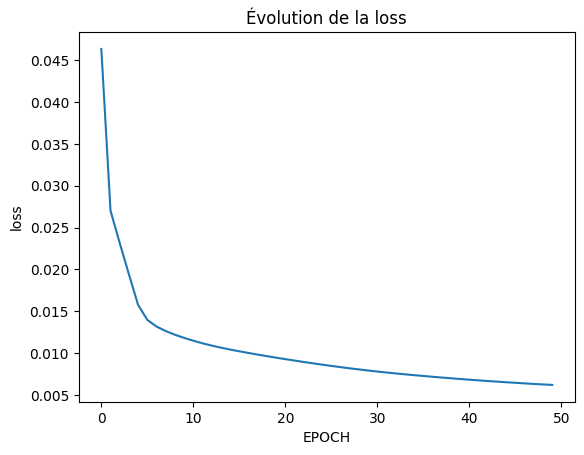

In [86]:
for epoch in range(epochs):

    print("Entering Epoch: ", epoch+1)
    for dirty, clean in tqdm((trainloader)):
        dirty = dirty.view(dirty.size(0), 1, 32*32).type(torch.FloatTensor)
        clean = clean.view(clean.size(0), 1, 32*32).type(torch.FloatTensor)
        dirty, clean = dirty.to(device), clean.to(device)

        # -----------------Forward Pass----------------------
        output = model(dirty)
        loss = criterion(output, clean)
        # -----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
    # -----------------Log-------------------------------
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch+1, epochs, loss.item()))



plt.plot(range(len(losslist)), losslist)
plt.title("Évolution de la loss")
plt.xlabel("EPOCH")
plt.ylabel("loss")

## Affichage des résultats

Les résultats de 6 éléments de la base de test sont affichés ici. La première colonne correspond à l'image initiale, la seconde l'image bruitée et la troisième l'image reconstruite par l'autoencodeur. La dernière colonne correspond à l'espace latent (entre l'encodeur et le décodeur).

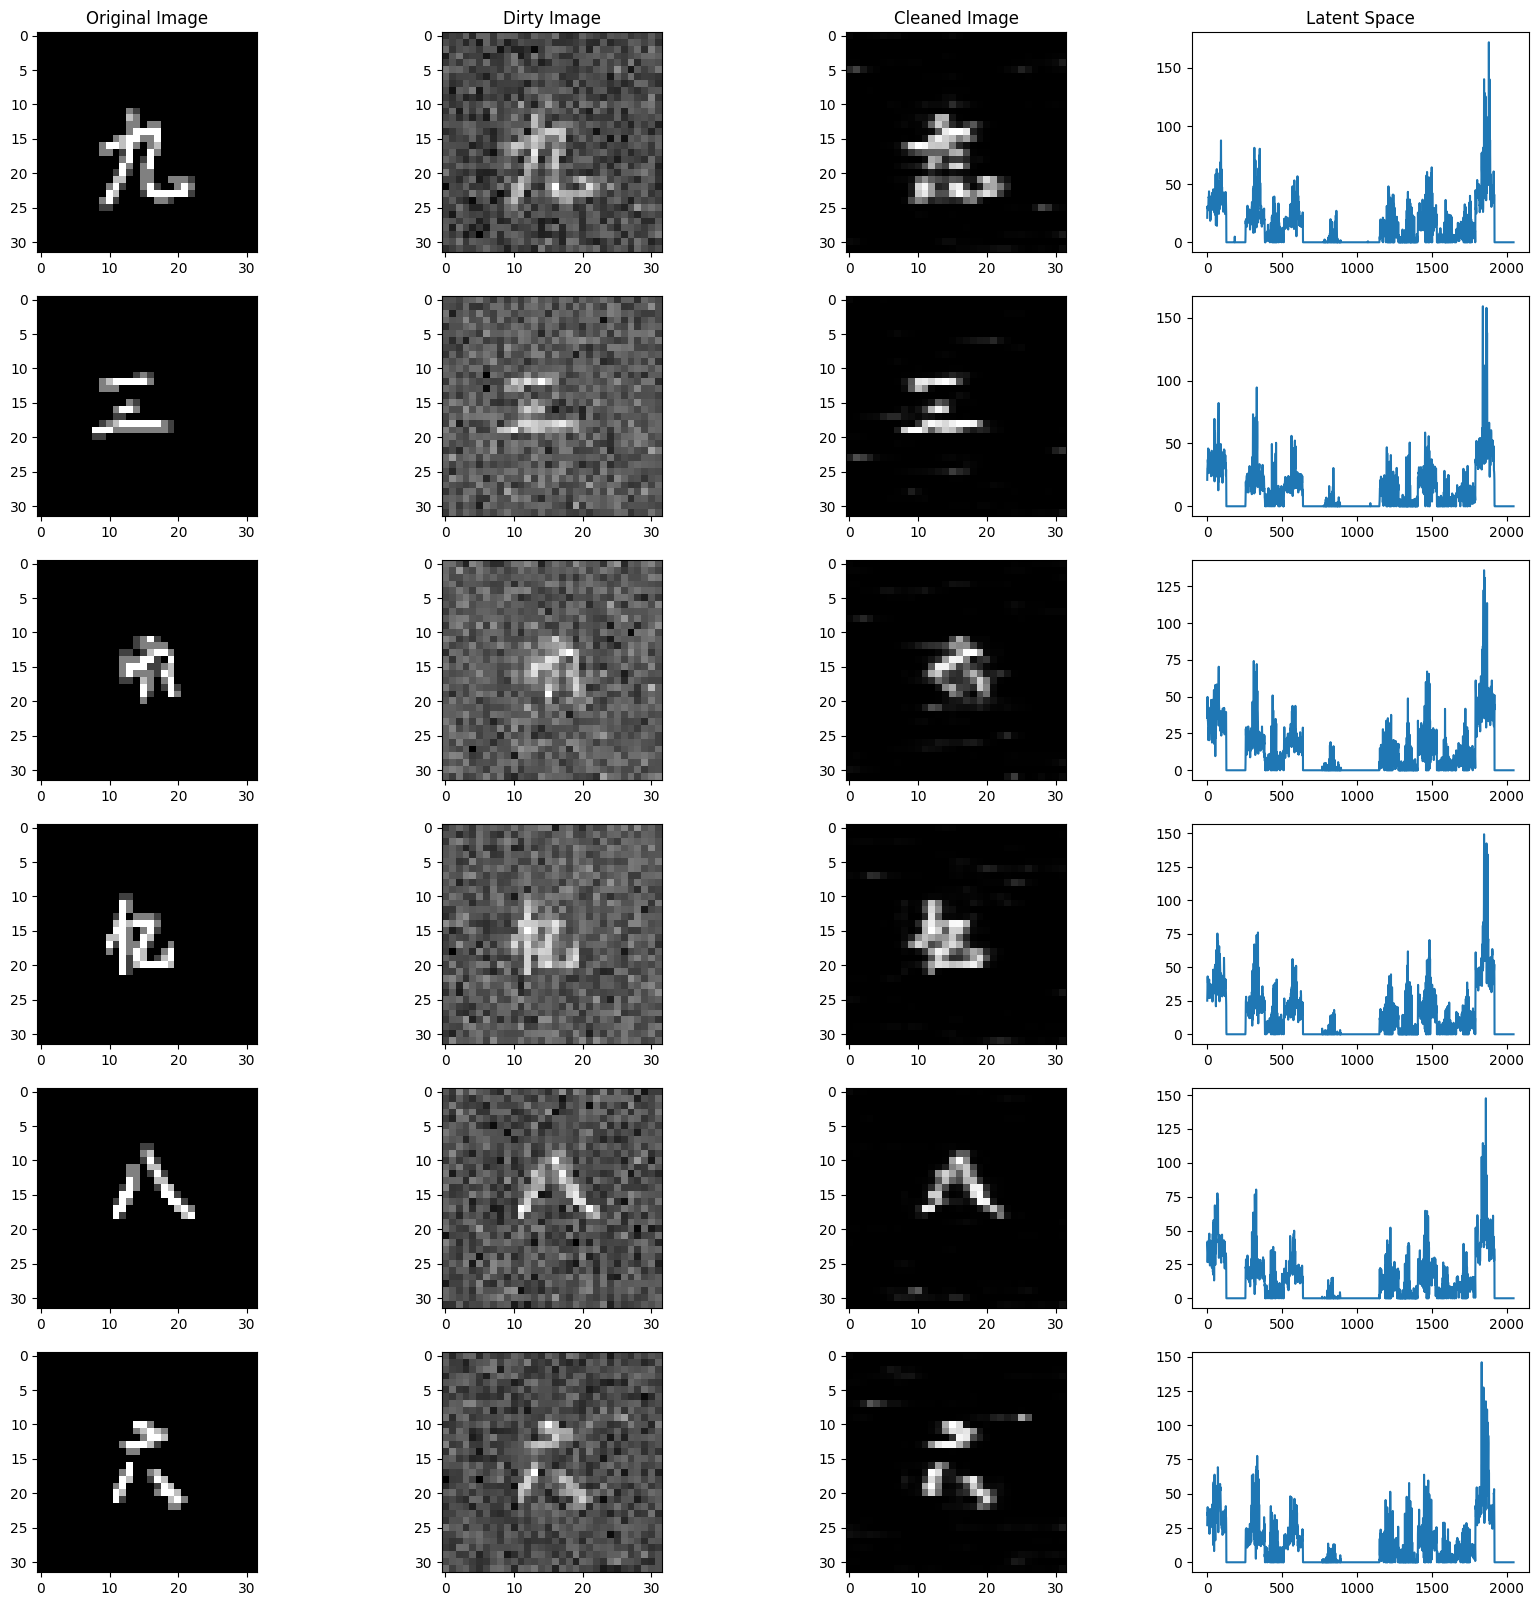

In [89]:
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Cleaned Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 500, size=6)
i = 0
for dirty, clean in testloader:
    i+=1
    dirty = dirty.view(dirty.size(0), 1, 32*32).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output_encoder = model.encoderConv1D(dirty)
    output_decoder = model.decoderConv1D(output_encoder)

    output = output_decoder.detach().cpu().numpy()
    output = output.reshape(32,32)

    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(32,32)

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(32,32)

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)

    axes[i-1, 0].imshow(clean, cmap="gray")
    axes[i-1, 1].imshow(dirty, cmap="gray")
    axes[i-1, 2].imshow(output, cmap="gray")
    axes[i-1, 3].plot(latent)

    if i == 6:
        break

plt.show()

## Enregistrement du réseau de neuronnes

In [90]:
PATH = "model/sinogrammeConv1D_10000.pth"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH